In [1]:
from init import *

In [2]:
matplotlib.rc('figure', figsize=(17, 14))

In [3]:
turbines = load_turbines()

# Compare mean wind speeds from ERA5 and GWA

This demonstrates why we need bias correction and why ERA5 resolution may not suffice in some hilly areas.

In [4]:
wind_speeds_gwa = xr.open_dataarray(INTERIM_DIR / 'wind_speed_gwa' / 'wind_speed_gwa100.nc', chunks=1000)

In [5]:
wind_velocities = load_wind_velocity([2015], MONTHS)

In [6]:
wind_speeds_era5 = ((wind_velocities.u100**2 + wind_velocities.v100**2)**0.5).mean(dim='time').compute()

In [7]:
def extract_gwa(xlong, ylat, half_gap=0.25/2.):
    return {
        'x': (xlong - half_gap <= wind_speeds_gwa.x) & (wind_speeds_gwa.x <= xlong + half_gap),
        'y': (ylat - half_gap <= wind_speeds_gwa.y) & (wind_speeds_gwa.y <= ylat + half_gap)
    }

In [8]:
xlong = turbines.sel(turbines=3110911).xlong
ylat = turbines.sel(turbines=3110911).ylat

In [9]:
extent = 0.25

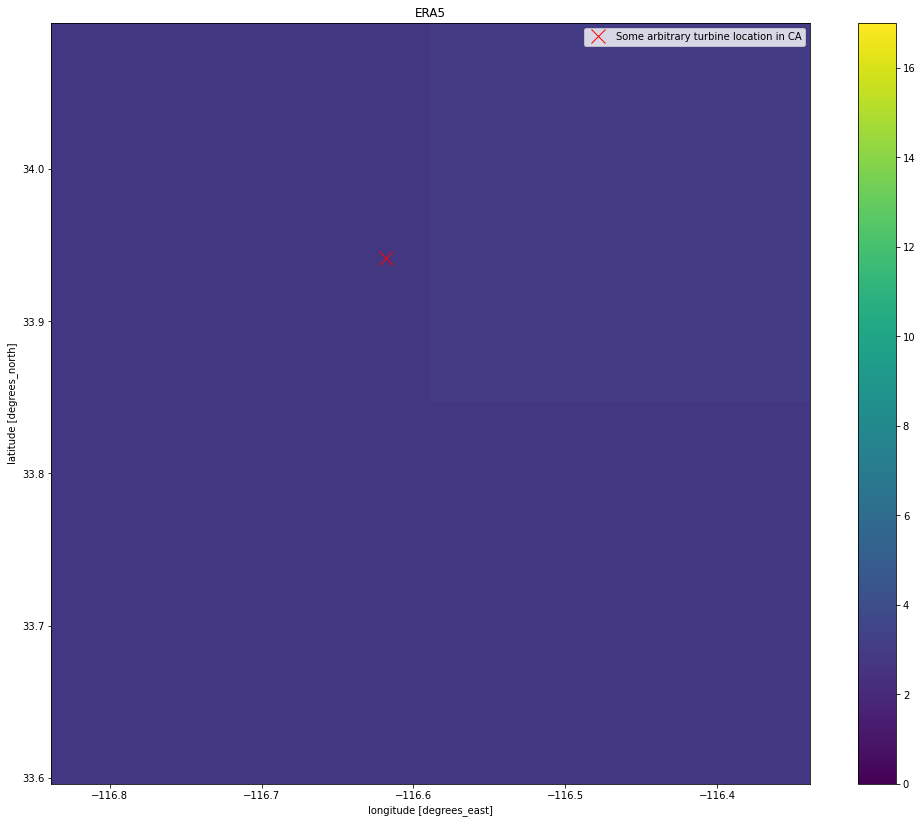

In [10]:
indcs = {
    'longitude': (xlong - extent <= wind_speeds_era5.longitude) & (wind_speeds_era5.longitude <= xlong + extent),
    'latitude': (ylat - extent <= wind_speeds_era5.latitude) & (wind_speeds_era5.latitude <= ylat + extent),
}
wind_speeds_era5.isel(**indcs).plot.imshow(vmin=0, vmax=17)
plt.plot(xlong, ylat, 'rx', markersize=14, label='Some arbitrary turbine location in CA')
plt.legend()
plt.title('ERA5');

The same turbine location and section in the GWA:

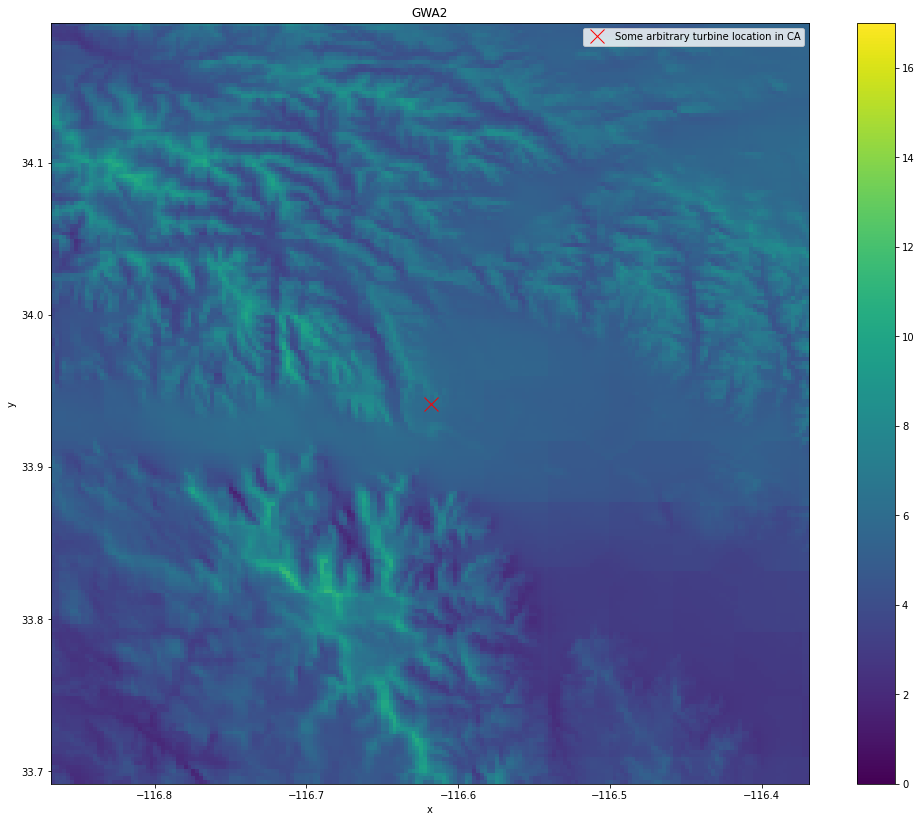

In [11]:
img = wind_speeds_gwa.isel(**extract_gwa(xlong, ylat, extent)).plot.imshow(vmin=0, vmax=17)
plt.plot(xlong, ylat, 'xr', markersize=14, label='Some arbitrary turbine location in CA')
plt.legend()
plt.title('GWA2');

A slice of the same plots at latitude 34° shows the differences in mean wind speeds even better:

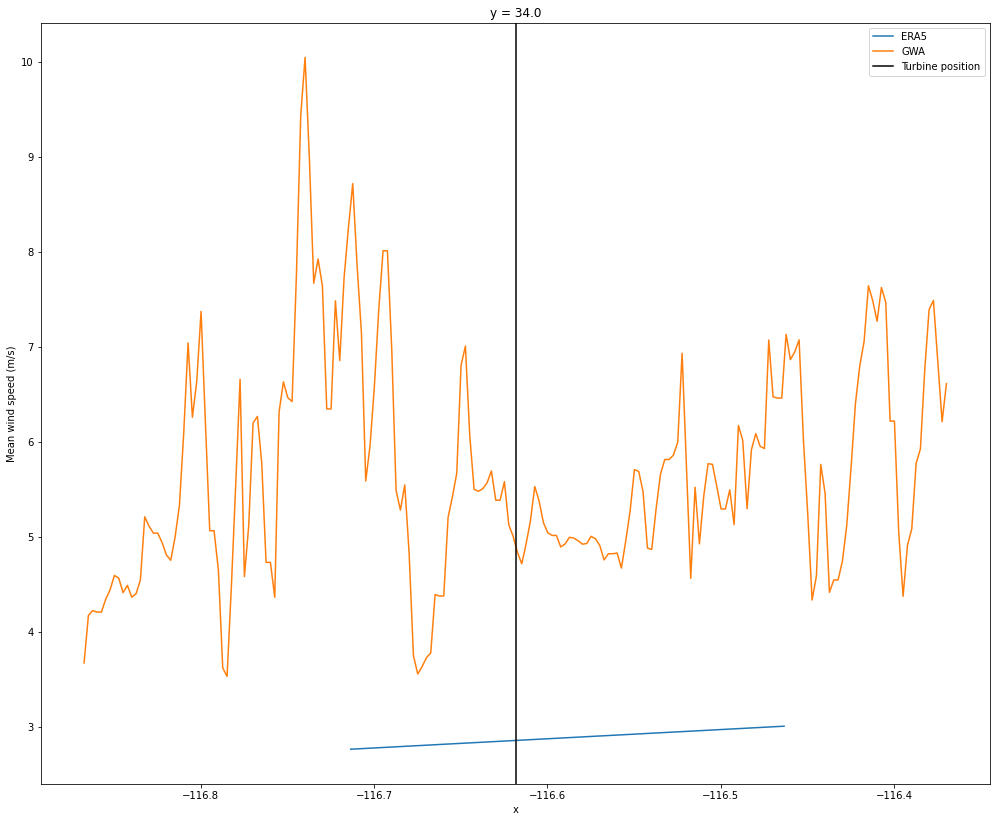

In [12]:
wind_speeds_era5.sel(latitude=34., method='nearest').sel(longitude=slice(xlong - extent, xlong + extent)).plot.line(label='ERA5')
gwa = wind_speeds_gwa.sel(y=34., method='nearest').sel(x=slice(xlong - extent, xlong + extent))
gwa.plot.line(label='GWA')
plt.ylabel('Mean wind speed (m/s)')
plt.axvline(xlong, color='k', label='Turbine position')
plt.legend();

The example above suggests that ERA5 has a lower mean wind speed (at turbine locations) than GWA2, but this is not further analyzed here.

# Wind speeds at turbines using GWA

Let's have a look at a histogram of mean wind speeds over all turbine locations to compare ERA5 and GWA2.

In [13]:
wind_speeds_era5_at_turbines = calc_wind_speed_at_turbines(wind_velocities, turbines, height=100).mean(dim='time')

/home/pregner/.conda/envs/wind_power_decomposition_usa/lib/python3.8/site-packages/dask/array/core.py:4697: PerformanceWarning: Increasing number of chunks by factor of 12
  result = blockwise(


In [14]:
wind_speeds_gwa_at_turbines = calc_wind_speed_at_turbines_gwa(wind_speeds_gwa, turbines)

In ERA5 there are quite some turbine locations with mean wind speeds below 5m/s and no locations with mean wind speeds above 8m/s.

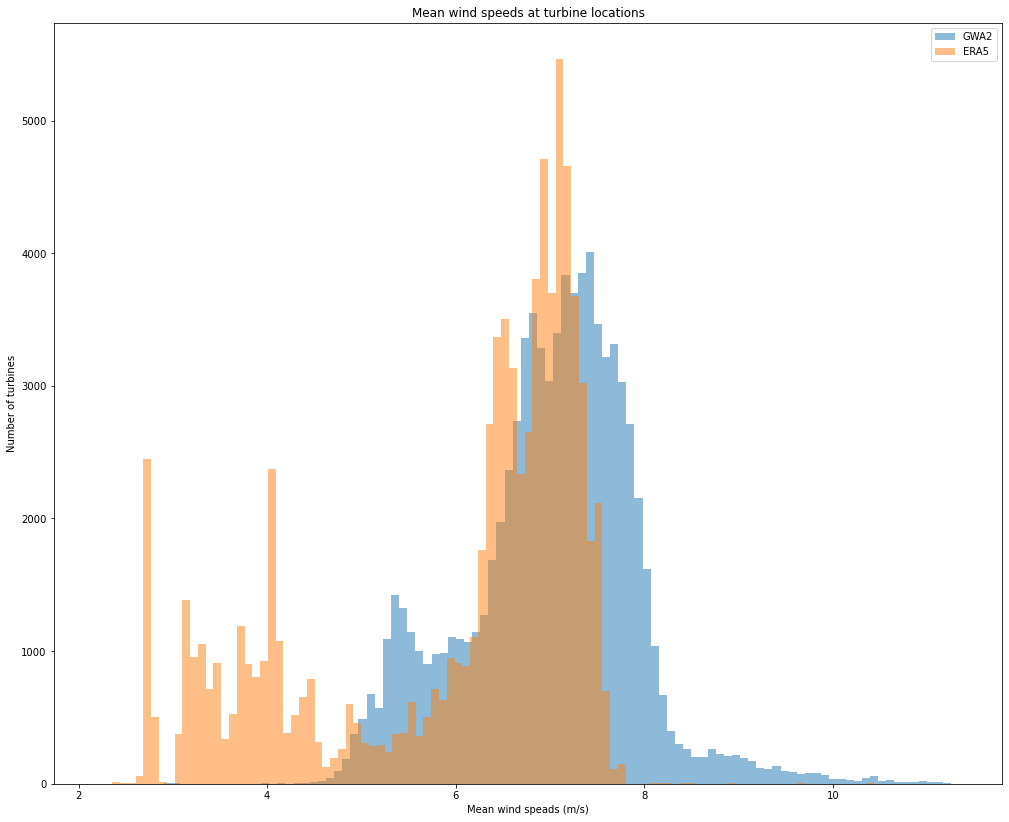

In [15]:
wind_speeds_gwa_at_turbines.plot.hist(bins=100, alpha=0.5, label='GWA2')
wind_speeds_era5_at_turbines.plot.hist(bins=100, alpha=0.5, label='ERA5');
plt.title('Mean wind speeds at turbine locations')
plt.ylabel('Number of turbines')
plt.xlabel('Mean wind speads (m/s)')
plt.legend();